## Import Libraries and Dataset

In [1]:
#import necessary libraries

import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Import dataset

df = pd.read_csv(r'C:\Users\Lenovo\Desktop\avocado.csv')

## Describe Data

The avocados dataframe consists of sales data for Hass avocados from 2015 to early 2017. In total, there are 14 columns: index, date, average price (of a single avocado), total volume sold, volume sold for three different avocado sizes (4046 = small, 4225 = large, 4770 = extra large), total volume of bags sold, volume of small, large and extra-large bags sold, type (conventional or organic), year, and region. There are 18249 rows.

## Data Cleaning

### Check For Missing Values and Wrong Datatypes

Firstly, use df.isna().sum() to check if there are any missing values in the dataset. Fortunately, there are none. Next, check if there are any duplicate rows by using df.drop_duplicates(). Again, there are none. Finally, run df.info() to ensure that the datatype for each column is appropriate. All of the numeric columns are either integer or float columns, while date, type and region are all object columns, so there are no problems here.

In [3]:
# Check for missing values

df.isna().sum()

# Drop any duplicates

df = df.drop_duplicates()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 18248
Data columns (total 14 columns):
Unnamed: 0      18249 non-null int64
Date            18249 non-null object
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: float64(9), int64(2), object(3)
memory usage: 2.1+ MB


### Re-order Dataset By Date

The data is currently ordered in rough chronological order, by year, but within the years and even within the months, it is not ordered by date. This is partly simply the way it has been assembled, but also because the data is ordered by urban area. For our purposes, to analyse pricing and volume trends, it will be necessary to observe the data ordered as a time series. Therefore, I converted the "Date" column to datetime and ordered the dataframe by this column.

In [4]:
# Change "Date" column to datetime

df["Date"] = pd.to_datetime(df["Date"])

# Order dataframe by "Date" column

df = df.sort_values(by="Date", ascending=True)

# Check .info() to check that the "Date" column is now datetime

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 11569 to 8814
Data columns (total 14 columns):
Unnamed: 0      18249 non-null int64
Date            18249 non-null datetime64[ns]
AveragePrice    18249 non-null float64
Total Volume    18249 non-null float64
4046            18249 non-null float64
4225            18249 non-null float64
4770            18249 non-null float64
Total Bags      18249 non-null float64
Small Bags      18249 non-null float64
Large Bags      18249 non-null float64
XLarge Bags     18249 non-null float64
type            18249 non-null object
year            18249 non-null int64
region          18249 non-null object
dtypes: datetime64[ns](1), float64(9), int64(2), object(2)
memory usage: 2.1+ MB


### Rename Columns

Rename the columns of the three avocado sizes to 'Small', 'Large' and 'Extra Large', and render all of the column names consistent in terms of spacing, capitalization, and so on. 'Region' is renamed to 'urban area', for reasons made clear below.

In [5]:
# Rename columns to make data clearer

df = df.rename(index=str, columns={"4046" : "Small", "4225" : "Large", "4770" : "Extra Large", "AveragePrice" : "Average Price",
                                   "XLarge Bags" : "Extra Large Bags", "type" : "Type", "year" : "Year", "region" : "Urban Area"})


### Check Column Formatting

Check that all of the entries in the "Type" column are either "conventional" or "organic", and that all of the entries in the "Year" column are between 2015 and 2017. No problems were found here. (Later, we will also check the consistency of the "Region" column).

In [6]:
# Check unique values in "Type" and "Year" columns to ensure consistency

print(df["Type"].unique())
print(df["Year"].unique())

['organic' 'conventional']
[2015 2016 2017 2018]


### Examine Distribution in Average Price Column

The average price of a single avocado is the dependent variable that we will be examining, so we need to make sure there are no invalid values (e.g. negative prices) or improbably high outliers, both of which would skew our data inaccurately. We can get an initial sense of this by using .describe() on the price column to print summary statistics, which show us that there are no negative values (the minimum value is 0.44, i.e. the cheapest avocado sold in the dataset was 44 cents), and that the maximum value is not implausibly high (an avocado which sold for $3.25). There are thus no obviously false values in the column.

Next, we can take a look at the mean, median and mode of the column. The mean and median are close (1.41 and 1.37), with a slightly higher mean, indicating a slight positive skew in the distribution. This is also indicated by the fact that the mean and median are significantly higher than the mode (1.15). We can also use the mode in conjunction with the mean and the standard deviation (available in summary statistics) to get the Pearson mode skewness of the data, using the formula (mean-mode)/std. This returns 0.65, confirming the slight positive skew in the data. Finally, we can plot a histogram of the column to visualize the distribution.

In [7]:
# Print summary statistics

df["Average Price"].describe()

count    18249.000000
mean         1.405978
std          0.402677
min          0.440000
25%          1.100000
50%          1.370000
75%          1.660000
max          3.250000
Name: Average Price, dtype: float64

In [8]:
# Compare mean, median and mode

print("Mean",round(df["Average Price"].mean(),2))
print("Median",round(df["Average Price"].median(),2))
print("Mode",round(df["Average Price"].mode(),2)[0])

Mean 1.41
Median 1.37
Mode 1.15


In [9]:
# Check Pearson Mode skewness: mean-mode / std

round((1.41-1.15) / 0.403,2)

0.65

Text(0.5, 0.98, 'Distribution of Average Price')

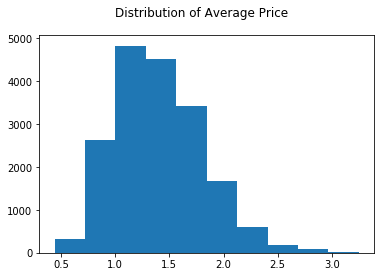

In [10]:
# Visualize the distribution of "Average Price" column as a histogram

plt.hist(df["Average Price"])
plt.suptitle("Distribution of Average Price")

### Limit Regions To Urban Areas

Our strategy is to target specific cities and urban agglomerations, rather than larger regions or states, so it will be easier to analyse the data if we remove states and regions from the dataset. This will leave us with a dataset comprised of data from either individual cities or cities that are grouped as part of a single urban agglomeration (e.g. Baltimore and Washington, D.C.). We will also remove the "TotalUS" rows, since we are not interested in the overall US trends. The resulting dataframe has 14869 rows, rather than 18249 as it had previously; 3380 rows have been removed. This process also showed that all of the unique region identifiers were genuinely unique, i.e. there were not multiple spellings of the same place, or variants with spaces that need to be removed, and so on.

In [11]:
# Identify unique rows in the "Urban Area" column

df["Urban Area"].unique()

# Create a list of non-urban regions to remove

regions_and_states = ["California", "GreatLakes", "Midsouth", "Northeast", "SouthCarolina", "Plains", "SouthCentral", 
                      "Southeast", "TotalUS", "West"]

# Create a new dataframe with the regions and states removed

df = df[~df["Urban Area"].isin(regions_and_states)]

## Identifying Target Markets

### Order Markets By Size

We can use the Pandas groupby function to group the urban markets in the dataframe according to the total volume of avocados sold in the period, and generate a bar plot to visualize the data. From this, it is clear that Los Angeles accounts for a far greater share of avocados sold than any other market. Following Los Angeles, we have New York, Dallas/Fort Worth, Houston, Phoenix/Tucson, and so on. Based upon our planned sales strategy, we could choose to target two of the top markets by size, and two from the lower ranges of the spectrum that could have good growth potential.

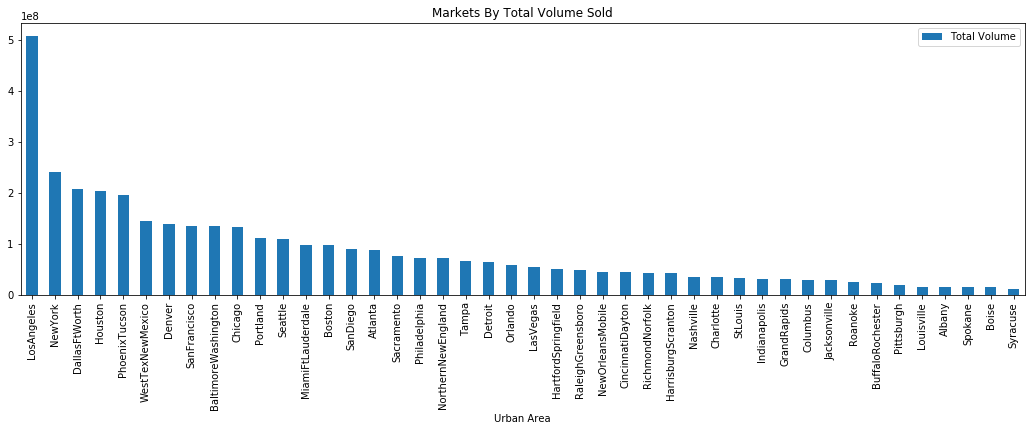

In [12]:
# Create a dataframe grouped by urban area

urban_grouped = df.groupby("Urban Area", as_index=False).agg({"Total Volume": "sum"})

# Plot a bar chart of grouped dataframe

urban_grouped.sort_values("Total Volume", ascending=False).plot.bar("Urban Area","Total Volume",figsize=(18,5),title="Markets By Total Volume Sold")

### Comparing Volume Sold and Average Price Per City/Urban Area

A scatter plot is the clearest way to visualize the relationship between individual cities/urban areas and the volume of avocados sold. Each point on the scatter plot represents the volume sold on a particular day and the average price on that day. To make it simple to look at cities individually, I created a function which takes as an input the name of the city/urban area and outputs a scatter plot.

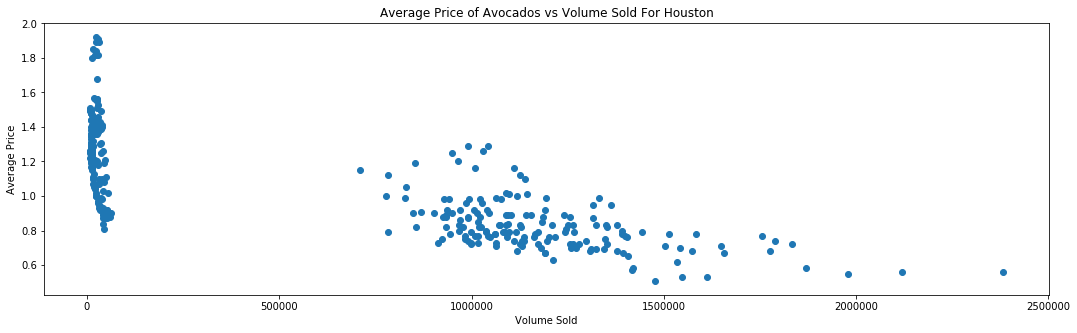

In [13]:
def volume_sold(x):
    if x in df["Urban Area"].values:
        temp_df = df[df["Urban Area"] == x]
        fig, ax = plt.subplots(figsize=(18,5))
        ax.set_ylabel("Average Price")
        ax.set_xlabel("Volume Sold")
        ax.set_title("Average Price of Avocados vs Volume Sold For " + x)
        ax.scatter(temp_df["Total Volume"], temp_df["Average Price"])
    else:
        print("Entry not recognized")
        
volume_sold("Houston")

However, there is a problem with the plots produced by the volume_sold function: the volume of organic avocados sold on a given day is typically far lower than the volume of conventional avocados. This means that the organic data is bunched up on the left-hand side of the plot and consequently difficult to interpret. I therefore created two more functions: one to return a plot for conventional avocados in a given city/urban area, and another to return a plot for organic avocados.

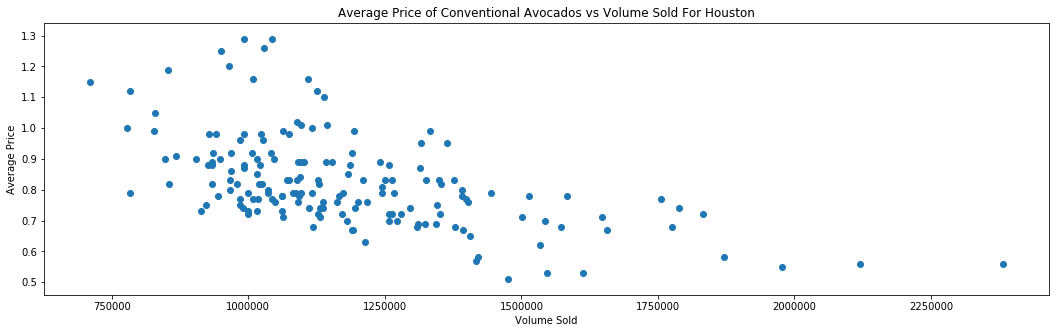

In [14]:
def volume_conventional(x):
    if x in df["Urban Area"].values:
        temp_df = df[df["Urban Area"] == x]
        temp_df = temp_df[temp_df["Type"] == "conventional"]
        fig, ax = plt.subplots(figsize=(18,5))
        ax.set_ylabel("Average Price")
        ax.set_xlabel("Volume Sold")
        ax.set_title("Average Price of Conventional Avocados vs Volume Sold For " + x)
        ax.scatter(temp_df["Total Volume"], temp_df["Average Price"])
    else:
        print("Entry not recognized")
        
volume_conventional("Houston")

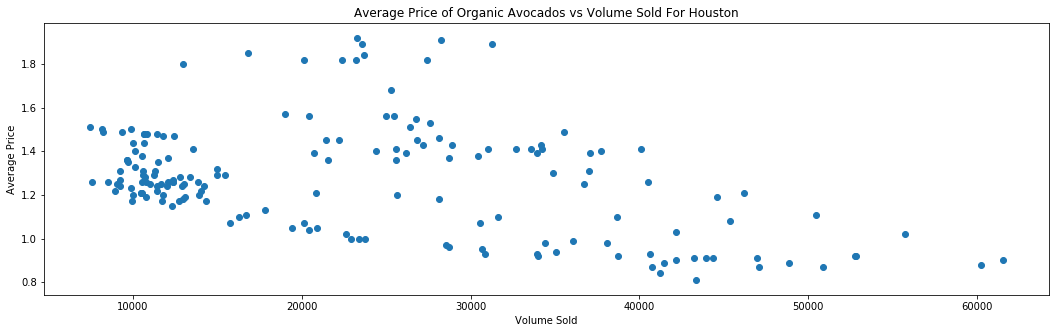

In [15]:
def volume_organic(x):
    if x in df["Urban Area"].values:
        temp_df = df[df["Urban Area"] == x]
        temp_df = temp_df[temp_df["Type"] == "organic"]
        fig, ax = plt.subplots(figsize=(18,5))
        ax.set_ylabel("Average Price")
        ax.set_xlabel("Volume Sold")
        ax.set_title("Average Price of Organic Avocados vs Volume Sold For " + x)
        ax.scatter(temp_df["Total Volume"], temp_df["Average Price"])
    else:
        print("Entry not recognized")
        
volume_organic("Houston")

### Order Markets By Average Price

If we group the data according to the average price per avocado for that region, we see a more gradual decline from the most expensive (Hartford-Springfield) to the least expensive region (Houston). This data could help us to select which markets to target. Perhaps markets with a relatively low volume of sales but a high average price would be good targets if we were able to sell avocados for less than the average price, for example.

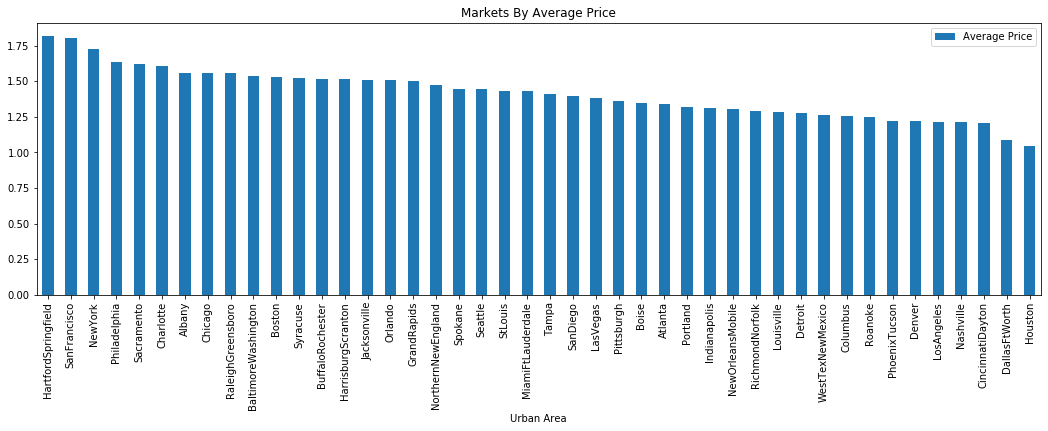

In [16]:
avg_price_urban = df.groupby("Urban Area", as_index=False).agg({"Average Price": "mean"})

avg_price_urban.sort_values("Average Price", ascending=False).plot.bar("Urban Area","Average Price",figsize=(18,5),title="Markets By Average Price")

### Examine Price Variation Over Time in Individual Urban Areas

A line chart can be plotted showing the fluctuations of the average avocado price over time for each city or urban area. For clarity, it is simpler to plot separate charts for conventional and organic avocados, since the prices vary greatly between these two groups. I have created two functions (one for conventional avocados, one for organic), which take as an input the name of a city/urban area in the "Urban Area" column, and output a line chart showing the behaviour of the average price over time. These functions mean we can easily compare variations in price for different cities/urban areas.

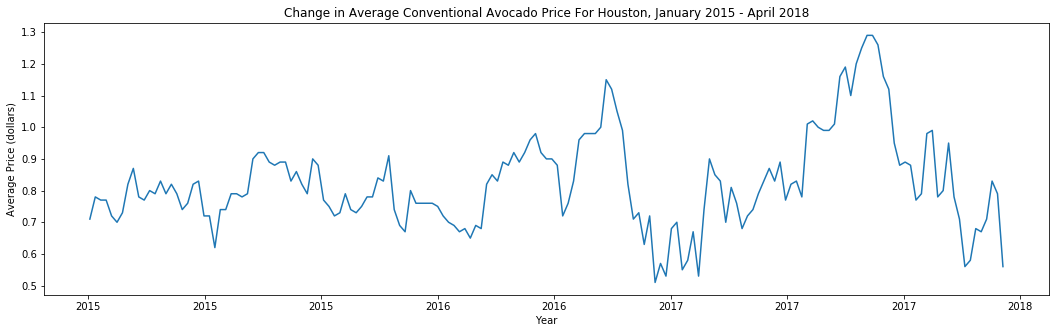

In [17]:
# Create a function which will show average price of conventional avocados over time for the inputted urban area

def avg_con_price(x):
    if x in df["Urban Area"].values:
        temp_df = df[df["Urban Area"] == x]
        temp_df = temp_df[temp_df["Type"] == "conventional"]
        fig, ax = plt.subplots(figsize=(18,5))
        loc = matplotlib.ticker.MultipleLocator(base=150.0)
        ax.xaxis.set_major_locator(loc)
        ax.set_ylabel("Average Price (dollars)")
        ax.set_xlabel("Year")
        ax.set_title("Change in Average Conventional Avocado Price For " + x + ", January 2015 - April 2018")
        ax.plot(temp_df["Date"], temp_df["Average Price"])
    else:
        print("Entry not recognized")
        
avg_con_price("Houston")

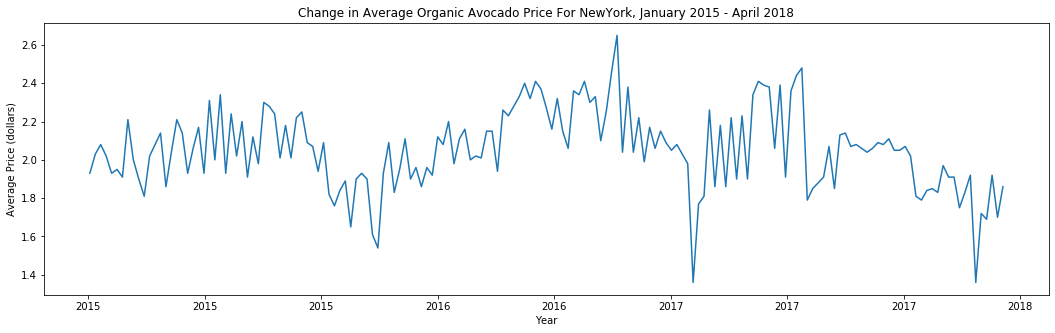

In [18]:
# Create a function which will show average price of conventional avocados over time for the inputted urban area

def avg_org_price(x):
    if x in df["Urban Area"].values:
        temp_df = df[df["Urban Area"] == x]
        temp_df = temp_df[temp_df["Type"] == "organic"]
        fig, ax = plt.subplots(figsize=(18,5))
        loc = matplotlib.ticker.MultipleLocator(base=150.0)
        ax.xaxis.set_major_locator(loc)
        ax.set_ylabel("Average Price (dollars)")
        ax.set_xlabel("Year")
        ax.set_title("Change in Average Organic Avocado Price For " + x + ", January 2015 - April 2018")
        ax.plot(temp_df["Date"], temp_df["Average Price"])
    else:
        print("Entry not recognized")
        
avg_org_price("NewYork")

### Examine Volume Sold Over Time in Individual Urban Areas

A function which allows us to look at the volume sold over time in individual urban areas is useful in helping us to determine which markets we should launch our products in. Markets demonstrating growth in more recent periods are more promising than those showing decline. This analysis might be combined with an examination of price fluctuations in the same era, to ensure that we don't launch the product in areas that seem to be experiencing a steep rise in prices, for example, as this may dampen demand. Again, the large discrepancy between organic and conventional avocados in terms of volume sold means the data is much easier to interpret if we use two different functions, one for conventional and one for organic.

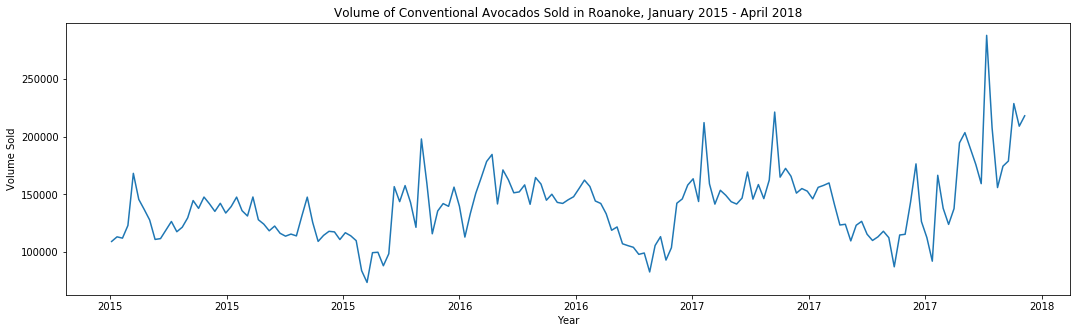

In [37]:
# Create a function which shows the variations in volume of conventional avocados sold over time for the inputted urban area



def vol_con_over_time(x):
    if x in df["Urban Area"].values:
        temp_df = df[df["Urban Area"] == x]
        temp_df = temp_df[temp_df["Type"] == "conventional"]
        temp_df.set_index(["Date"])
        fig, ax = plt.subplots(figsize=(18,5))
        loc = matplotlib.ticker.MultipleLocator(base=150.0)
        ax.xaxis.set_major_locator(loc)
        ax.set_ylabel("Volume Sold")
        ax.set_xlabel("Year")
        ax.set_title("Volume of Conventional Avocados Sold in " + x + ", January 2015 - April 2018")
        ax.plot(temp_df["Date"], temp_df["Total Volume"])
    else:
        print("Entry not recognized")
        
vol_con_over_time("Roanoke")

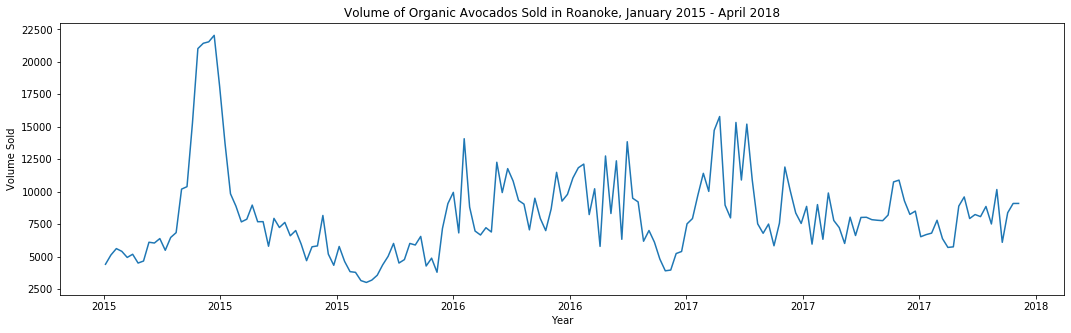

In [20]:
# Create a function which shows the variations in volume of organic avocados sold over time for the inputted urban area

def vol_org_over_time(x):
    if x in df["Urban Area"].values:
        temp_df = df[df["Urban Area"] == x]
        temp_df = temp_df[temp_df["Type"] == "organic"]
        fig, ax = plt.subplots(figsize=(18,5))
        loc = matplotlib.ticker.MultipleLocator(base=150.0)
        ax.xaxis.set_major_locator(loc)
        ax.set_ylabel("Volume Sold")
        ax.set_xlabel("Year")
        ax.set_title("Volume of Organic Avocados Sold in " + x + ", January 2015 - April 2018")
        ax.plot(temp_df["Date"], temp_df["Total Volume"])
    else:
        print("Entry not recognized")
        
vol_org_over_time("Roanoke")

### Conventional or Organic?

Using the functions I have created above, we can compare the fluctuations in how many avocados are sold over time for individual cities depending upon whether they are conventional or organic. A common difference between these two categories is that the variation in volume for conventional avocados is somewhat more predictable: while there are always short-term fluctuations, in the longer term it is easier to identify growth. This means that it is a safer strategy to initially focus on the production and sale of conventional avocados. Coupled with this of course is the fact that the market for conventional avocados is much larger, as noted above.

#### I would therefore advise us to focus, at least initially, on the production and sale of conventional avocados alone.

### Target Markets

Our goal is to identify two large urban markets and two small ones in which to launch our product. For the moment, we will only be producing conventional avocados, so the relevant functions are those which show us fluctuations in price and volume sold for conventional avocados.

The list of potential markets in alphabetical order, with spelling and formatting as it is in the dataframe (obtained using .unique()) is as follows:

'Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston' 'BuffaloRochester' 'Charlotte' 'Chicago' 'CincinnatiDayton' 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis' 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale' 'Nashville' 'NewOrleansMobile' 'NewYork' 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson' 'Pittsburgh' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk' 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle' 'Spokane' 'StLouis' 'Syracuse' 'Tampa' 'WestTexNewMexico'.

By examining the trends in the areas of volume sold and price variation, I have determined two large urban markets and two small ones which I would advise us to launch conventional avocados in. These decisions were based upon long-term growth trends in terms of the volume of avocados consumed in these urban areas, as well as stable or decreasing average price per avocado, giving us some assurance that prices are not likely to jump and thus potentially cause a sudden drop in demand, at least in the short-term.

#### The two large markets I have selected are Houston and Chicago; the two smaller ones are Louisville and Roanoke.

## Using Inferential Statistics to Predict Pricing and Volume Sold

Firstly, I have created a heatmap to show the correlations between variables in the dataset. The variable that correlates most closely with average price is total volume (-0.44 correlation), so that will be one of the variables used in our regression model that aims to predict price. Our second regression model will aim to predict the volume of conventional avocados sold by looking at the relationship between price variations and volume sold.

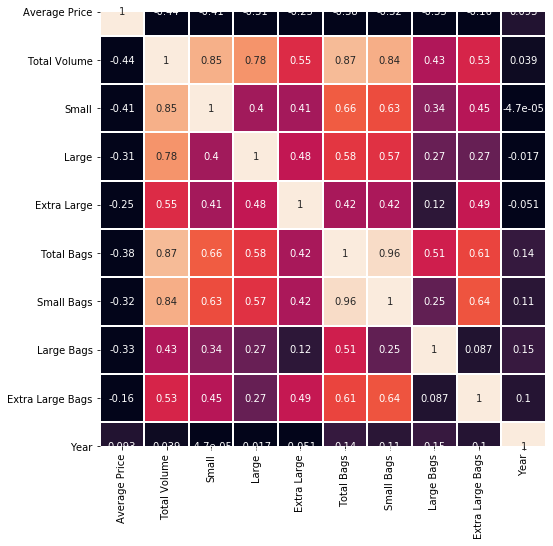

In [21]:
# Produce a heatmap showing correlations between variables in the dataset

filt = ['Average Price', 'Total Volume', 'Small', 'Large',
       'Extra Large', 'Total Bags', 'Small Bags', 'Large Bags',
       'Extra Large Bags', 'Type', 'Year', 'Urban Area']

matrix = df[filt].corr()

plt.subplots(figsize=(8, 8))
heatmap = sns.heatmap(matrix, linewidths = 1, annot = True, cbar = False, vmin = 0, vmax = 1)

### Using OLS Regression to Predict Price

I created a dataframe consisting only of conventional avocados, since that is the product we will be selling. I then created a list of independent variables to be used in predicting price (total volume, total bags, and year). Next, for each city we are targeting, I used an OLS model to output predicted results for the period in question.

In [22]:
# Create a new dataframe limited to conventional avocados

df_con = df[df["Type"] == "conventional"]

# create a list of independent variables

indep = ["Total Volume", "Total Bags","Year"]

# create a specific dataframe for each target city

houston_df = df_con[df_con["Urban Area"] == "Houston"]
chicago_df = df_con[df_con["Urban Area"] == "Chicago"]
louisville_df = df_con[df_con["Urban Area"] == "Louisville"]
roanoke_df = df_con[df_con["Urban Area"] == "Roanoke"]

# create OLS models for target cities

reg_houston = sm.OLS(endog=houston_df["Average Price"], exog=houston_df[indep])
reg_chicago = sm.OLS(endog=chicago_df["Average Price"], exog=chicago_df[indep])
reg_louisville = sm.OLS(endog=louisville_df["Average Price"], exog=louisville_df[indep])
reg_roanoke = sm.OLS(endog=roanoke_df["Average Price"], exog=roanoke_df[indep])

# fit models

results_houston = reg_houston.fit()
results_chicago = reg_chicago.fit()
results_louisville = reg_louisville.fit()
results_roanoke = reg_roanoke.fit()

# print OLS regression results

print(results_houston.summary(),results_chicago.summary(),results_louisville.summary(),results_roanoke.summary())

                                 OLS Regression Results                                
Dep. Variable:          Average Price   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              4516.
Date:                Tue, 23 Jun 2020   Prob (F-statistic):                   7.89e-159
Time:                        12:58:40   Log-Likelihood:                          162.99
No. Observations:                 169   AIC:                                     -320.0
Df Residuals:                     166   BIC:                                     -310.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

We can now create line charts plotting the predicted arrays for average price against the actual prices at the same index point. To do this, I needed to turn all of the results into arrays, and also create an array of the actual prices for each city's dataframe, before plotting these.

In [23]:
# Create arrays of predictions

houston_pred_array = results_houston.predict()
chicago_pred_array = results_chicago.predict()
louisville_pred_array = results_louisville.predict()
roanoke_pred_array = results_roanoke.predict()

# Create arrays of actual average prices

houston_dep_array = houston_df["Average Price"].array.astype(float)
chicago_dep_array = chicago_df["Average Price"].array.astype(float)
louisville_dep_array = louisville_df["Average Price"].array.astype(float)
roanoke_dep_array = roanoke_df["Average Price"].array.astype(float)

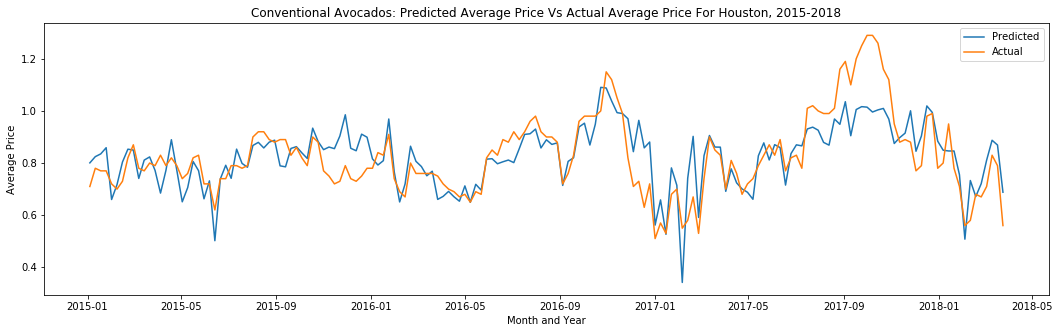

In [24]:
# Plot Houston chart

plt.figure(figsize=(18,5))
plt.title("Conventional Avocados: Predicted Average Price Vs Actual Average Price For Houston, 2015-2018")
plt.ylabel("Average Price")
plt.xlabel("Month and Year")
plt.plot(houston_df["Date"], houston_pred_array, label = "Predicted")
plt.plot(houston_df["Date"], houston_dep_array, label = "Actual")
plt.legend()

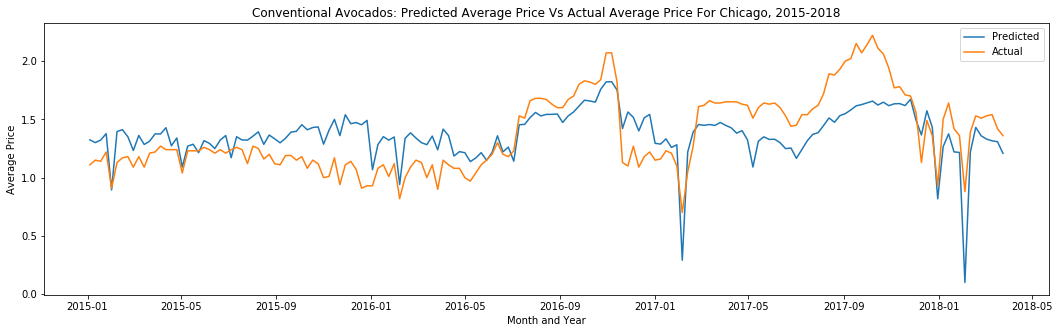

In [25]:
# Plot Chicago chart

plt.figure(figsize=(18,5))
plt.title("Conventional Avocados: Predicted Average Price Vs Actual Average Price For Chicago, 2015-2018")
plt.ylabel("Average Price")
plt.xlabel("Month and Year")
plt.plot(chicago_df["Date"], chicago_pred_array, label = "Predicted")
plt.plot(chicago_df["Date"], chicago_dep_array, label = "Actual")
plt.legend()

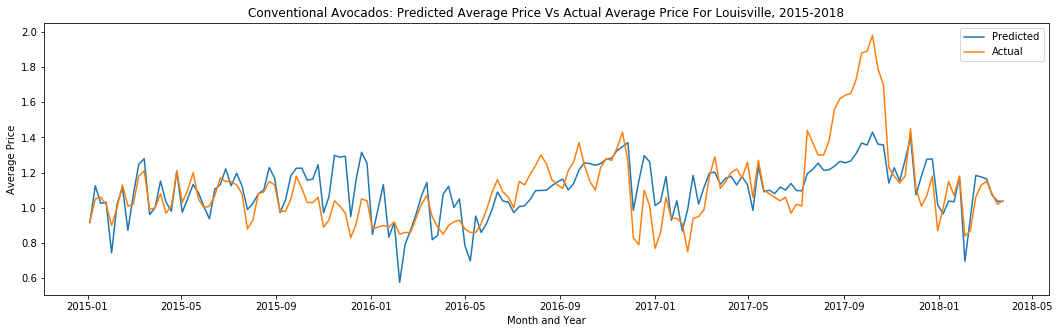

In [26]:
# Plot Louisville chart

plt.figure(figsize=(18,5))
plt.title("Conventional Avocados: Predicted Average Price Vs Actual Average Price For Louisville, 2015-2018")
plt.ylabel("Average Price")
plt.xlabel("Month and Year")
plt.plot(louisville_df["Date"], louisville_pred_array, label = "Predicted")
plt.plot(louisville_df["Date"], louisville_dep_array, label = "Actual")
plt.legend()

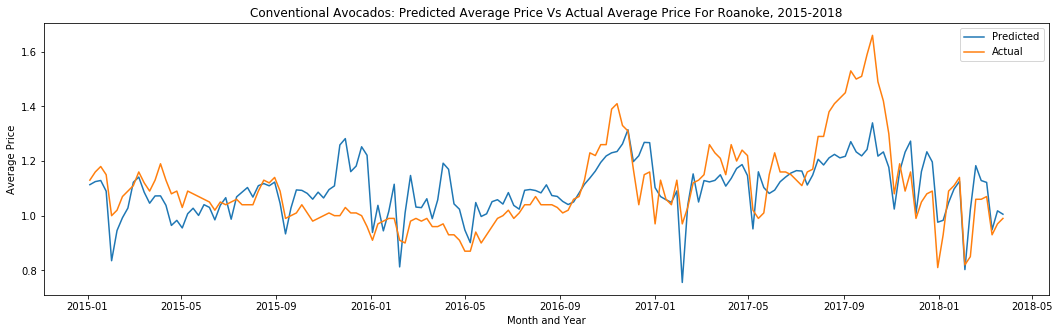

In [27]:
# Plot Roanoke chart

plt.figure(figsize=(18,5))
plt.title("Conventional Avocados: Predicted Average Price Vs Actual Average Price For Roanoke, 2015-2018")
plt.ylabel("Average Price")
plt.xlabel("Month and Year")
plt.plot(roanoke_df["Date"], roanoke_pred_array, label = "Predicted")
plt.plot(roanoke_df["Date"], roanoke_dep_array, label = "Actual")
plt.legend()

### Predicting Volume Sold

Using the dataframes created above, which show only data for conventional avocados in the cities I have selected, I next used total volume as the dependent variable with price and year as the independent variables, to analyse how fluctuations in price impact upon demand. Again, I used an OLS model to output predicted results for the period in question.

In [28]:
# create a list of independent variables

indep_2 = ["Average Price","Year"]

# create OLS models for target cities

reg_2_houston = sm.OLS(endog=houston_df["Total Volume"], exog=houston_df[indep_2])
reg_2_chicago = sm.OLS(endog=chicago_df["Total Volume"], exog=chicago_df[indep_2])
reg_2_louisville = sm.OLS(endog=louisville_df["Total Volume"], exog=louisville_df[indep_2])
reg_2_roanoke = sm.OLS(endog=roanoke_df["Total Volume"], exog=roanoke_df[indep_2])

# fit models

results_2_houston = reg_2_houston.fit()
results_2_chicago = reg_2_chicago.fit()
results_2_louisville = reg_2_louisville.fit()
results_2_roanoke = reg_2_roanoke.fit()

# print OLS regression results

print(results_2_houston.summary(),results_2_chicago.summary(),results_2_louisville.summary(),results_2_roanoke.summary())

                                 OLS Regression Results                                
Dep. Variable:           Total Volume   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              2642.
Date:                Tue, 23 Jun 2020   Prob (F-statistic):                   4.01e-127
Time:                        12:58:41   Log-Likelihood:                         -2311.8
No. Observations:                 169   AIC:                                      4628.
Df Residuals:                     167   BIC:                                      4634.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

We can now create line charts plotting the predicted arrays for volume sold against the actual volume sold at the same index point. To do this, I needed to turn all of the results into arrays, and also create an array of the actual volume sold for each city's dataframe, before plotting these.

In [29]:
# Create arrays of predictions

houston_pred_2_array = results_2_houston.predict()
chicago_pred_2_array = results_2_chicago.predict()
louisville_pred_2_array = results_2_louisville.predict()
roanoke_pred_2_array = results_2_roanoke.predict()

# Create arrays of actual average prices

houston_dep_2_array = houston_df["Total Volume"].array.astype(float)
chicago_dep_2_array = chicago_df["Total Volume"].array.astype(float)
louisville_dep_2_array = louisville_df["Total Volume"].array.astype(float)
roanoke_dep_2_array = roanoke_df["Total Volume"].array.astype(float)

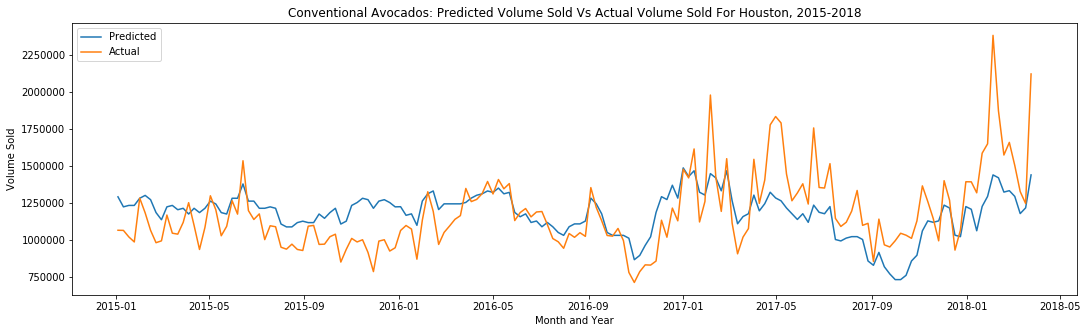

In [30]:
# Plot Houston chart

plt.figure(figsize=(18,5))
plt.title("Conventional Avocados: Predicted Volume Sold Vs Actual Volume Sold For Houston, 2015-2018")
plt.ylabel("Volume Sold")
plt.xlabel("Month and Year")
plt.plot(houston_df["Date"], houston_pred_2_array, label = "Predicted")
plt.plot(houston_df["Date"], houston_dep_2_array, label = "Actual")
plt.legend()

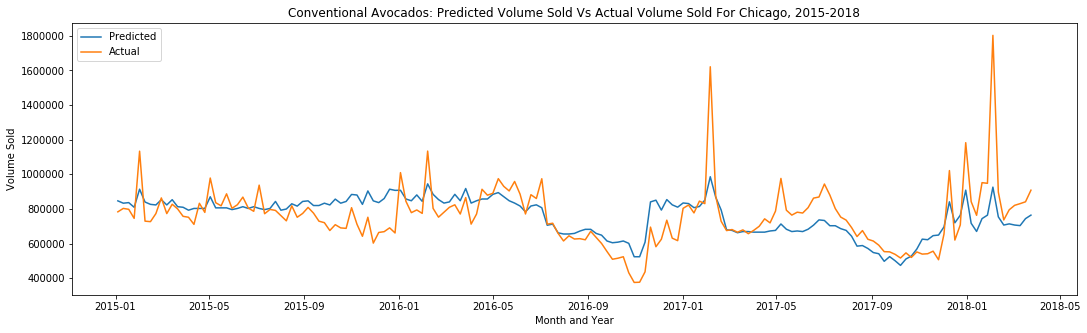

In [31]:
# Plot Chicago chart

plt.figure(figsize=(18,5))
plt.title("Conventional Avocados: Predicted Volume Sold Vs Actual Volume Sold For Chicago, 2015-2018")
plt.ylabel("Volume Sold")
plt.xlabel("Month and Year")
plt.plot(chicago_df["Date"], chicago_pred_2_array, label = "Predicted")
plt.plot(chicago_df["Date"], chicago_dep_2_array, label = "Actual")
plt.legend()

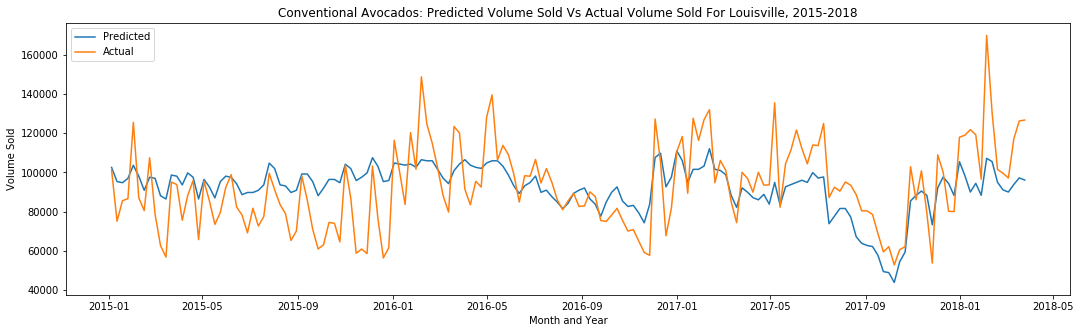

In [32]:
# Plot Louisville chart

plt.figure(figsize=(18,5))
plt.title("Conventional Avocados: Predicted Volume Sold Vs Actual Volume Sold For Louisville, 2015-2018")
plt.ylabel("Volume Sold")
plt.xlabel("Month and Year")
plt.plot(louisville_df["Date"], louisville_pred_2_array, label = "Predicted")
plt.plot(louisville_df["Date"], louisville_dep_2_array, label = "Actual")
plt.legend()

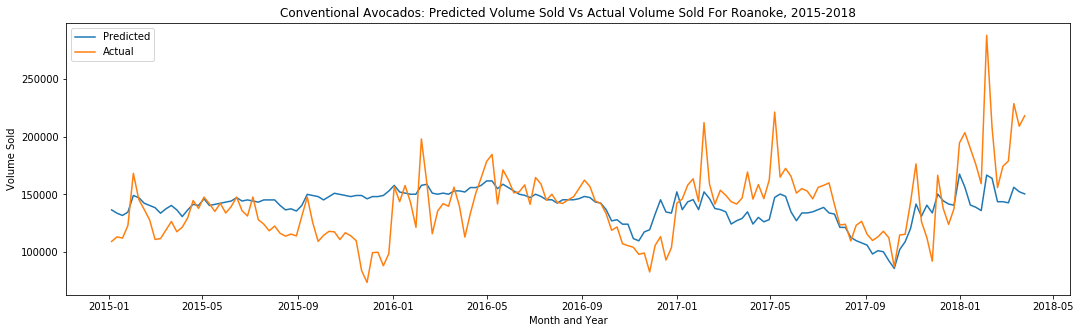

In [33]:
# Plot Roanoke chart

plt.figure(figsize=(18,5))
plt.title("Conventional Avocados: Predicted Volume Sold Vs Actual Volume Sold For Roanoke, 2015-2018")
plt.ylabel("Volume Sold")
plt.xlabel("Month and Year")
plt.plot(roanoke_df["Date"], roanoke_pred_2_array, label = "Predicted")
plt.plot(roanoke_df["Date"], roanoke_dep_2_array, label = "Actual")
plt.legend()

## Insights

My exploration of this data has produced several key insights that can inform executive decisions regarding our entry into the avocado market. Our first important step was looking at the different markets in terms of size, since our goal was to identify two large urban markets and two small ones in which to launch our product. This visualization shows us the size of the markets in ascending order:

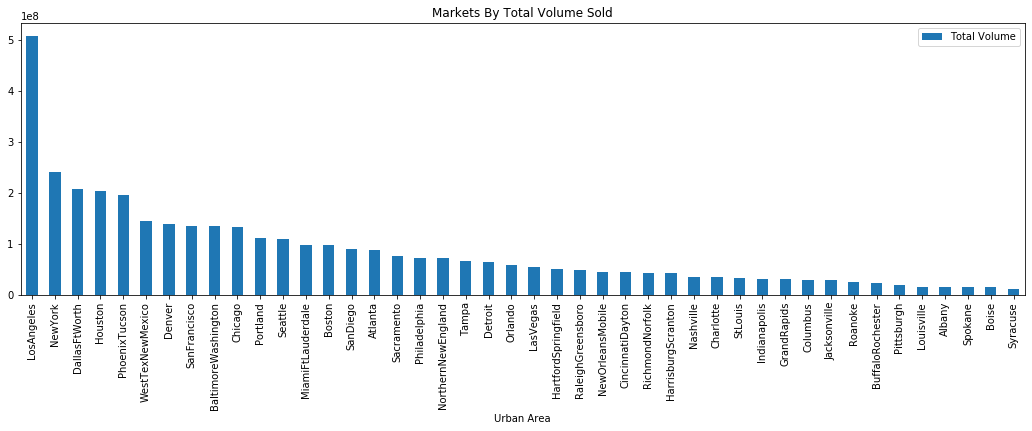

Next, I examined the relationship between the average price of avocados and the total volume sold, by using scatter plots. As noted above, our first scatter plot function included both conventional and avocados, and it revealed the much lower volume of organic avocados sold, as these will be clustered in the top-left area of the chart for any selected urban area. The example below, for Houston, is typical:

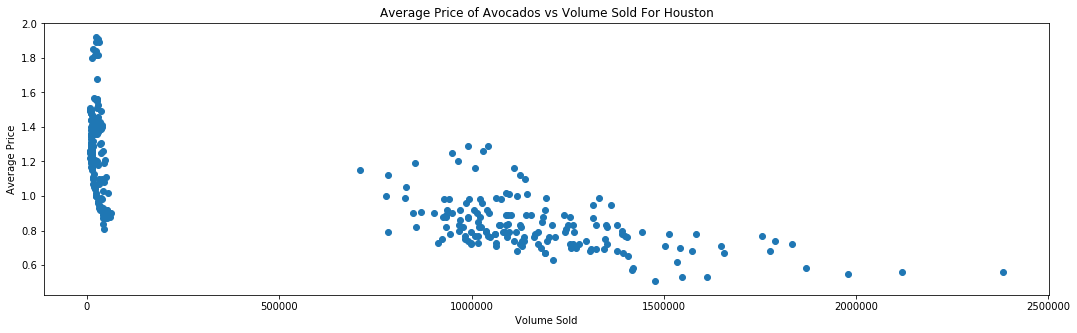

The above chart helped to drive my recommendation that we should focus for the time being on selling conventional avocados only, since this is clearly a much larger market. This recommendation was also informed by an analysis of the fluctuations in volume sold for organic avocados as compared to conventional ones. If we look at the small but growing market of Roanoke, for example, we can see that even accounting for seasonal variations, there is a long-term growth trend for conventional avocados, and particularly promising short-term trends:

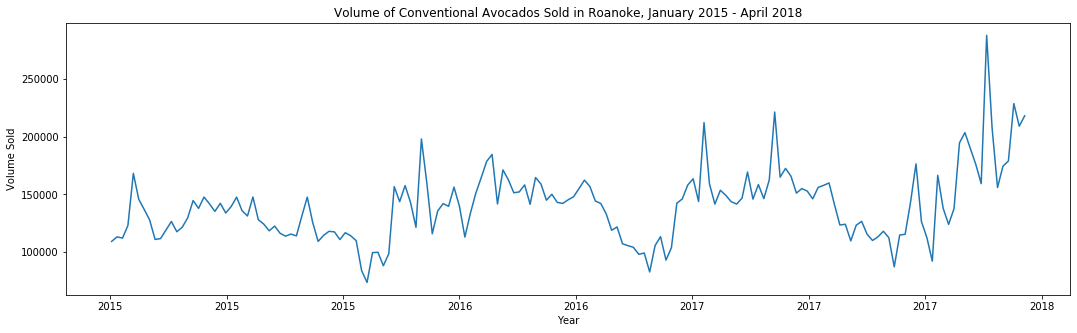

However, for the same city, the market for organic avocados is less promising:

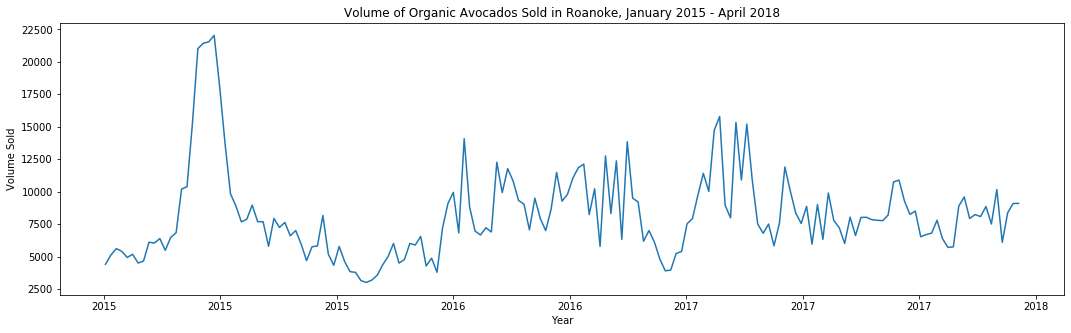

Thus, taking into consideration both the relatively low volume of organic avocado sales (across all markets) and the typically more unpredictable nature of their popularity, I recommended that we focus only upon selling conventional avocados for now.

Next, by examining the trends in the areas of volume sold and price variation, I determined two large urban markets and two small ones which I would advise us to launch conventional avocados in. These decisions were based upon long-term growth trends in terms of the volume of avocados consumed in these urban areas, as well as the stable or decreasing average price per avocado, giving us some assurance that prices are not likely to jump and thus potentially cause a sudden drop in demand, at least in the short-term. The two large markets I selected were Houston and Chicago; the two smaller ones were Louisville and Roanoke. If we look at the behaviour of prices for Houston, for example, we can see that this looks like a good time to enter the market, since they are relatively low, and therefore demand should remain strong as long as this trend continues:

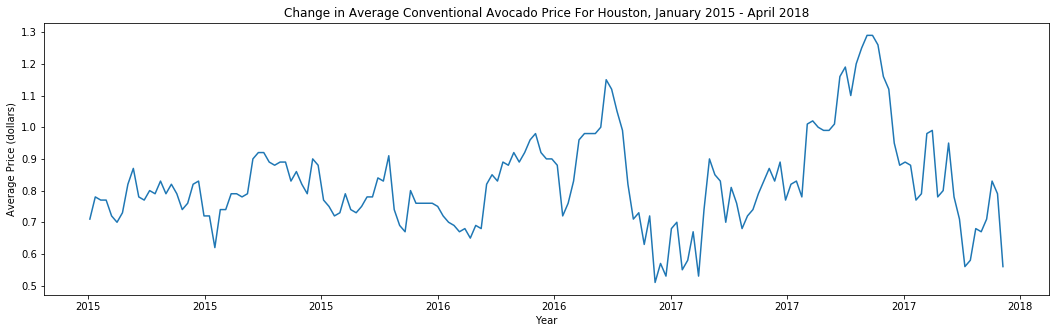

Looking at the volume sold, we can see that it has indeed risen in response to the low prices:
    
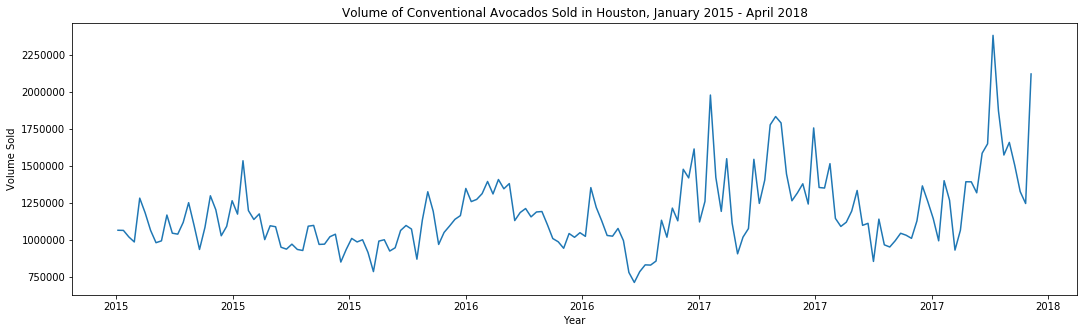

These judgements informed my recommendations for our target markets in all four instances.

Finally, I carried out some inferential statistics to help us to predict future fluctations in price and volume sold, looking at the ways in which these two key variables are related to each other. The OLS regression models I produced should help us to account for things like seasonal increases or decreases in avocado prices or in volume sold, allowing us to budget more effectively, maintain efficient supply chains, develop marketing campaigns at appropriate times, and so on. These visualizations show predicted versus average prices and predicted versus average volume for Chicago:

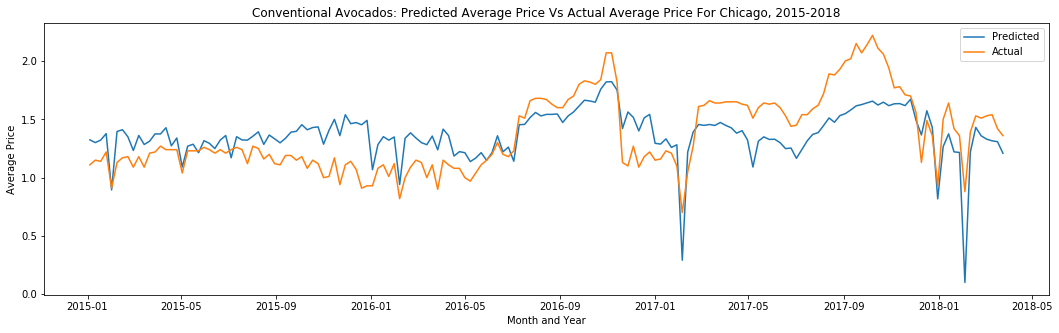

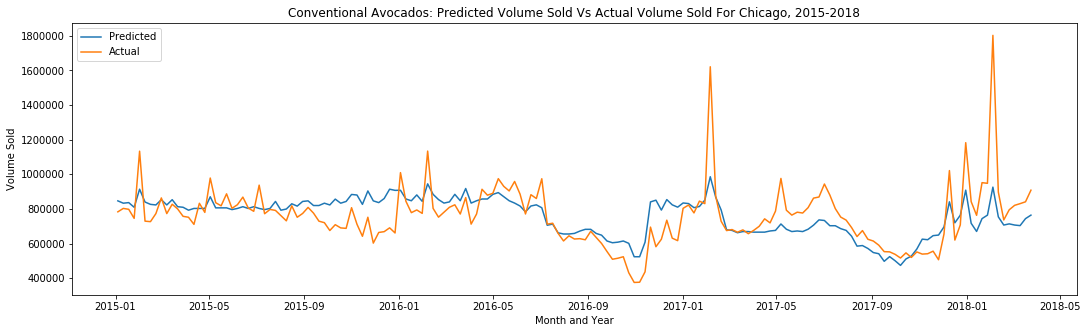